<a href="https://colab.research.google.com/github/iamshivaay2003/SPECTRA/blob/main/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install catboost imbalanced-learn transformers

import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import joblib

In [4]:
print("\n Loading datasets...")
log_data = pd.read_csv("/content/HDFS_100k.log_structured.csv")
label_data = pd.read_csv("/content/anomaly_label.csv")


 Loading datasets...


In [5]:
print("\n Extracting BlockId...")
log_data['BlockId'] = log_data['Content'].str.extract(r'(blk_[\d\-]+)')


 Extracting BlockId...


In [6]:
print("\n Merging log and label data...")
data = pd.merge(log_data, label_data, how='inner', on='BlockId')
data.drop(['LineId', 'Date', 'Time', 'Pid', 'Component', 'EventTemplate', 'BlockId'], axis=1, inplace=True, errors='ignore')



 Merging log and label data...


In [7]:
print("\n Loading BERT model...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


 Loading BERT model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [8]:
def get_bert_embeddings(text):
    """Generate BERT embeddings for a given log content."""
    tokens = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokens = {key: val.to(device) for key, val in tokens.items()}
    with torch.no_grad():
        output = model(**tokens)
    return output.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

In [9]:
print("\n Generating BERT embeddings...")
X = np.array([get_bert_embeddings(log) for log in tqdm(data['Content'])])
y = data['Label'].apply(lambda x: 1 if x == 'Anomaly' else 0).values


 Generating BERT embeddings...


100%|██████████| 104815/104815 [16:04<00:00, 108.70it/s]


<ipython-input-10-f891154198ed>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Label', palette='Set2', ax=axs[0, 0])
<ipython-input-10-f891154198ed>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[1] for x in normal_common], y=[x[0] for x in normal_common], palette='Greens_r', ax=axs[1, 0])


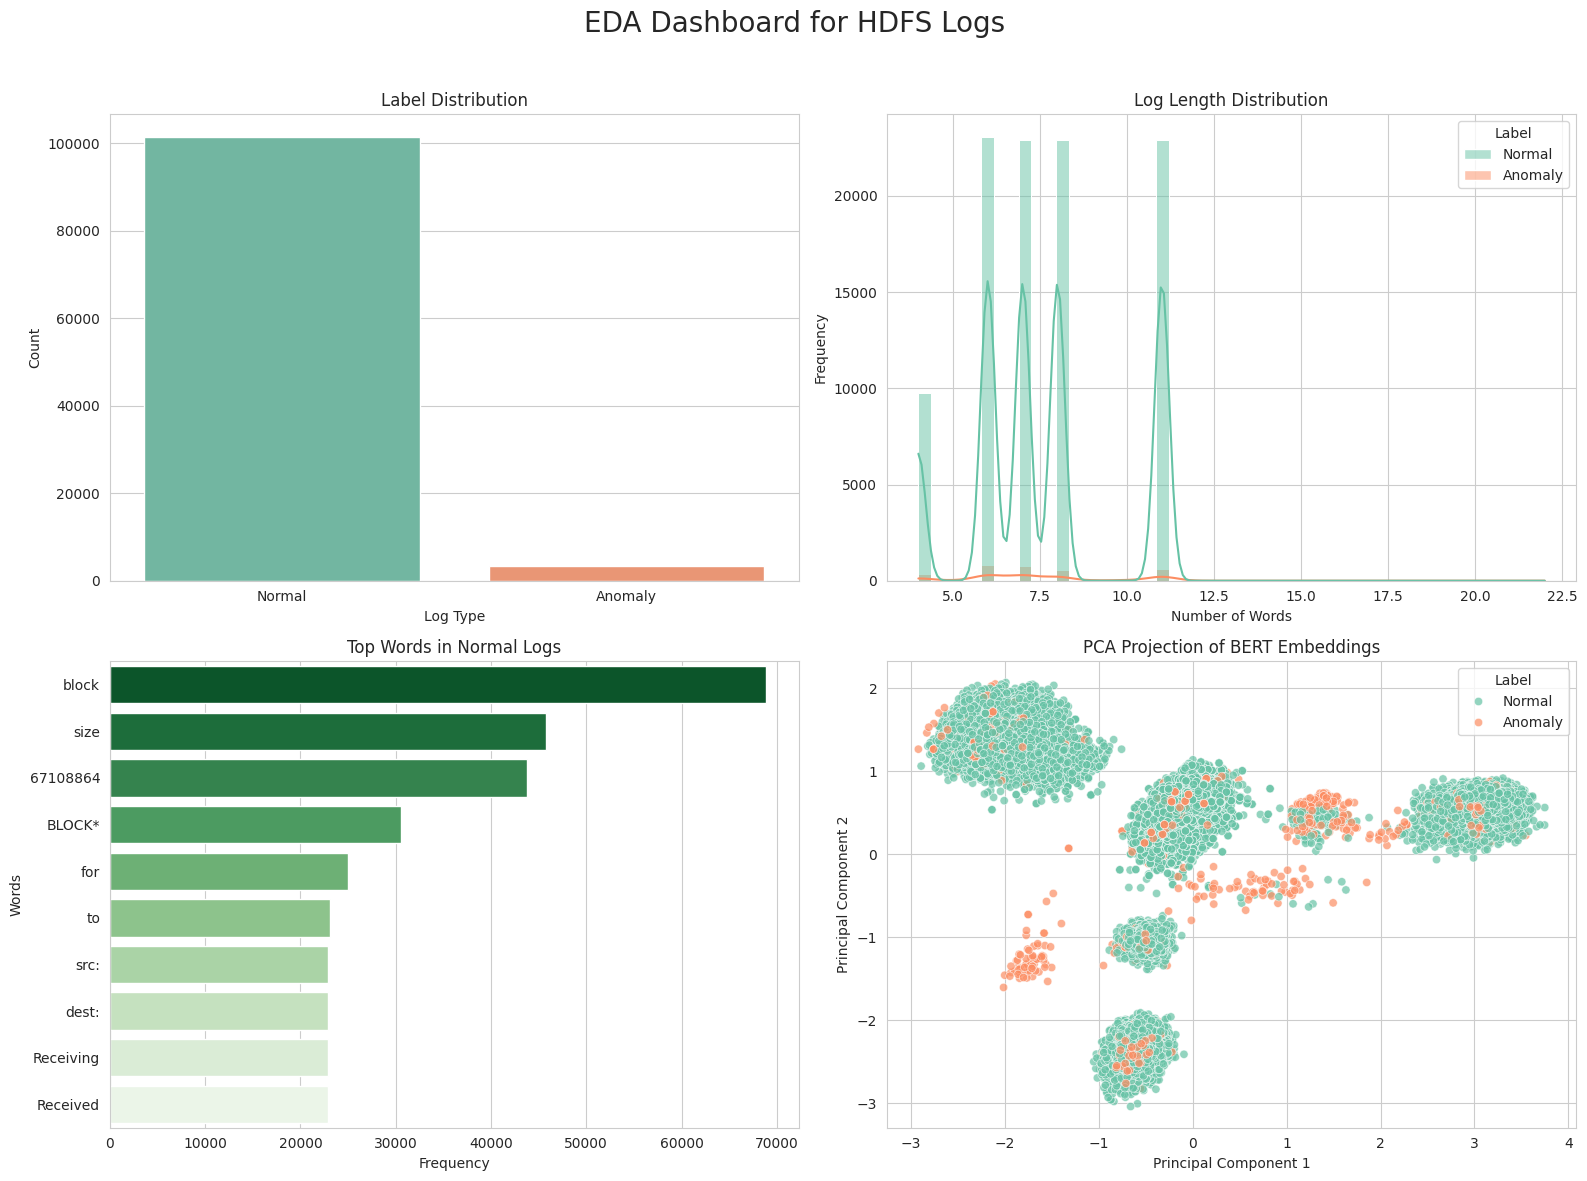

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import itertools
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Set style
sns.set_style("whitegrid")

# Add Log Length Feature
data['LogLength'] = data['Content'].apply(lambda x: len(str(x).split()))

# Tokenize logs and count common words
normal_logs = data[data['Label'] == 'Normal']['Content'].apply(lambda x: x.split())
anomaly_logs = data[data['Label'] == 'Anomaly']['Content'].apply(lambda x: x.split())

normal_words = list(itertools.chain.from_iterable(normal_logs))
anomaly_words = list(itertools.chain.from_iterable(anomaly_logs))

normal_common = Counter(normal_words).most_common(10)
anomaly_common = Counter(anomaly_words).most_common(10)

# PCA on BERT Embeddings
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df['Label'] = ['Anomaly' if label == 1 else 'Normal' for label in y]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("EDA Dashboard for HDFS Logs", fontsize=20)

# Plot 1: Label Distribution
sns.countplot(data=data, x='Label', palette='Set2', ax=axs[0, 0])
axs[0, 0].set_title("Label Distribution")
axs[0, 0].set_xlabel("Log Type")
axs[0, 0].set_ylabel("Count")

# Plot 2: Log Length Distribution
sns.histplot(data, x='LogLength', hue='Label', bins=50, kde=True, palette='Set2', ax=axs[0, 1])
axs[0, 1].set_title("Log Length Distribution")
axs[0, 1].set_xlabel("Number of Words")
axs[0, 1].set_ylabel("Frequency")

# Plot 3: Top Words in Normal Logs
sns.barplot(x=[x[1] for x in normal_common], y=[x[0] for x in normal_common], palette='Greens_r', ax=axs[1, 0])
axs[1, 0].set_title("Top Words in Normal Logs")
axs[1, 0].set_xlabel("Frequency")
axs[1, 0].set_ylabel("Words")

# Plot 4: PCA Scatter of BERT Embeddings
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Label", palette='Set2', ax=axs[1, 1], alpha=0.7)
axs[1, 1].set_title("PCA Projection of BERT Embeddings")
axs[1, 1].set_xlabel("Principal Component 1")
axs[1, 1].set_ylabel("Principal Component 2")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [11]:
print("\n Splitting and balancing dataset...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


 Splitting and balancing dataset...


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(y_true, y_pred, title="Confusion Matrix"):
    confmat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [13]:
print("\n Training CatBoost model...")
cat_model = CatBoostClassifier(
    iterations=200, depth=6, learning_rate=0.1,
    loss_function='Logloss', verbose=0, scale_pos_weight=1.5
)
cat_model.fit(X_train, y_train)
joblib.dump(cat_model, 'catboost_log_model.pkl')



 Training CatBoost model...


['catboost_log_model.pkl']


 Evaluating CatBoost model...
CatBoost Accuracy: 0.8926482359460625
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.81      0.88     16116
           1       0.84      0.98      0.90     16366

    accuracy                           0.89     32482
   macro avg       0.91      0.89      0.89     32482
weighted avg       0.90      0.89      0.89     32482



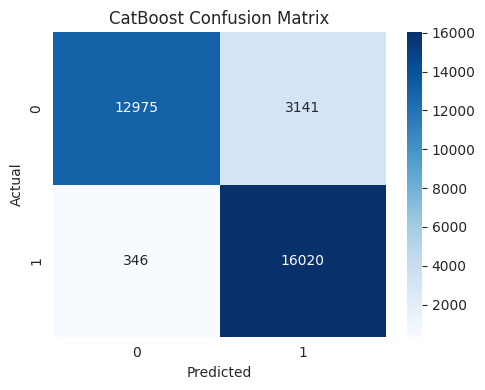

In [14]:
print("\n Evaluating CatBoost model...")
y_cat_pred = cat_model.predict(X_test)
print("CatBoost Accuracy:", accuracy_score(y_test, y_cat_pred))
print("Classification Report:\n", classification_report(y_test, y_cat_pred))
plot_conf_matrix(y_test, y_cat_pred, title="CatBoost Confusion Matrix")


In [15]:
print("\n Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, 'rf_log_model.pkl')



 Training Random Forest model...


['rf_log_model.pkl']


 Evaluating Random Forest model...
Random Forest Accuracy: 0.8964041623052768
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89     16116
           1       0.85      0.96      0.90     16366

    accuracy                           0.90     32482
   macro avg       0.90      0.90      0.90     32482
weighted avg       0.90      0.90      0.90     32482



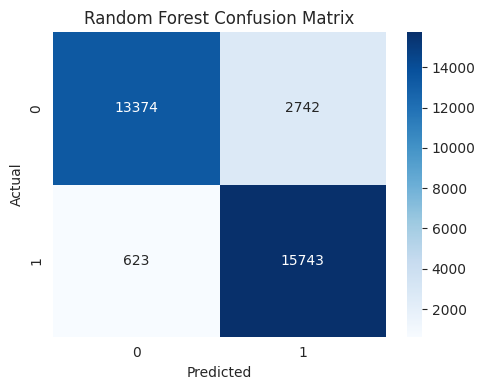

In [16]:
print("\n Evaluating Random Forest model...")
y_rf_pred = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_rf_pred))
print("Classification Report:\n", classification_report(y_test, y_rf_pred))
plot_conf_matrix(y_test, y_rf_pred, title="Random Forest Confusion Matrix")

In [17]:
print("\n Training MLP model...")
mlp_model = MLPClassifier(
    hidden_layer_sizes=(256, 128), activation='relu',
    solver='adam', alpha=1e-4, batch_size=32,
    learning_rate='adaptive', max_iter=10, random_state=42
)
mlp_model.fit(X_train, y_train)
joblib.dump(mlp_model, 'mlp_log_model.pkl')



 Training MLP model...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


['mlp_log_model.pkl']


 Evaluating MLP model...
MLP Accuracy: 0.9097346222523244
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91     16116
           1       0.93      0.89      0.91     16366

    accuracy                           0.91     32482
   macro avg       0.91      0.91      0.91     32482
weighted avg       0.91      0.91      0.91     32482



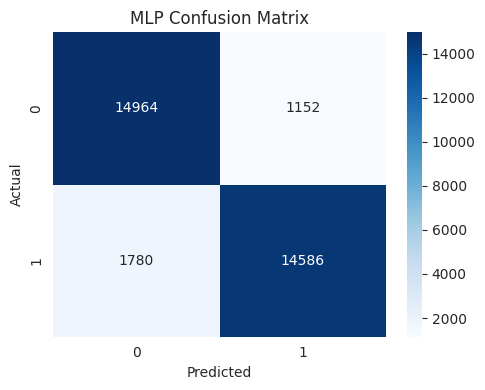

In [18]:
print("\n Evaluating MLP model...")
y_mlp_pred = mlp_model.predict(X_test)
print("MLP Accuracy:", accuracy_score(y_test, y_mlp_pred))
print("Classification Report:\n", classification_report(y_test, y_mlp_pred))
plot_conf_matrix(y_test, y_mlp_pred, title="MLP Confusion Matrix")

In [19]:
print("\n Creating and training VotingClassifier ensemble...")
ensemble = VotingClassifier(
    estimators=[
        ('catboost', cat_model),
        ('random_forest', rf_model),
        ('mlp', mlp_model)
    ],
    voting='hard'
)
ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)

print("\n Ensemble Model Accuracy:", accuracy_score(y_test, y_pred))


 Creating and training VotingClassifier ensemble...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



 Ensemble Model Accuracy: 0.9271288713749153



 Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92     16116
           1       0.89      0.98      0.93     16366

    accuracy                           0.93     32482
   macro avg       0.93      0.93      0.93     32482
weighted avg       0.93      0.93      0.93     32482



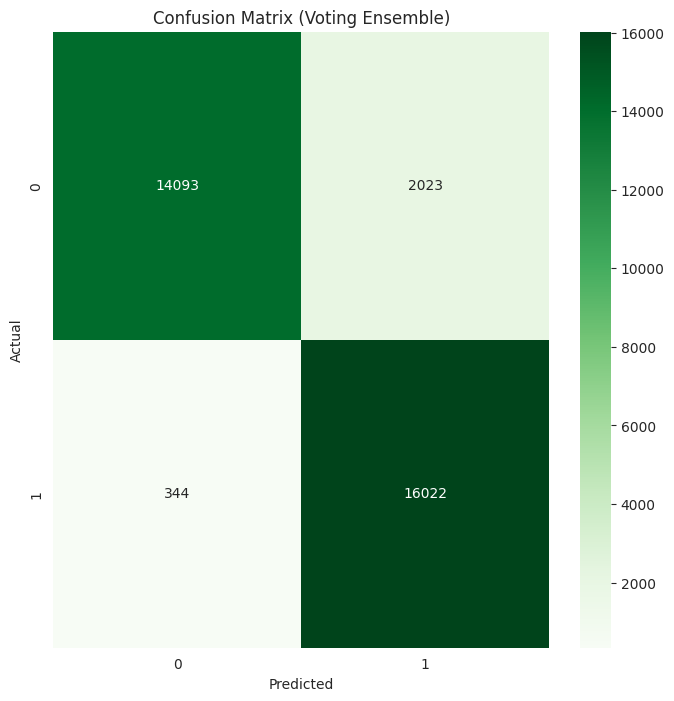

In [20]:
print("\n Classification Report:\n", classification_report(y_test, y_pred))

confmat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confmat, annot=True, fmt='d', cmap='Greens', ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Voting Ensemble)')
plt.show()

In [21]:
joblib.dump(ensemble, 'ensemble_log_model.pkl')
print("\n Ensemble model saved as 'ensemble_log_model.pkl'")


 Ensemble model saved as 'ensemble_log_model.pkl'
